In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import UnivariateSpline

sys.path.append("../lib/")

from lib import master_calendar


In [3]:
df_raw = pd.read_csv("data/input/concept2-season-2020.csv")

# columns to drop (empty, with duplicated values or identical constants)
col_to_drop = [
    "Stroke Count",  # empty
    "Avg Heart Rate",  # empty
    "Comments",  # empty
    "Weight",  # constant ("Lwt")
    "Type",  # constant ("Indoor Rower")
    "Ranked",  # constant ("No")
    "Work Time (Formatted)",  # string duplicate (of float "Work Time (seconds)")
    "Rest Time (Formatted)",  #  string duplicate (of float "Rest Time (seconds)")
    "Age",  # constant ("26" or "27", negligeable difference)
    "Cal/Hour",  # duplicate (similar to power in watts per units of time)
]
df = df_raw.drop(col_to_drop, axis="columns")

In [4]:
# renaming based on preferences
dict_naming = {
    "ID": "session_id",
    "Description": "session_type",
    "Date": "session_timestamp",
    "Work Time (Seconds)": "work_in_s",
    "Rest Time (Seconds)": "rest_in_s",
    "Work Distance": "work_in_m",
    "Rest Distance": "rest_in_m",
    "Stroke Rate/Cadence": "spm",
    "Pace": "time_split",
    "Total Cal": "cal_burned",
    "Drag Factor": "drag_factor",
    
    "Avg Watts": "power_in_avg_w",
}
df.rename(columns=dict_naming, inplace=True)

df["session_date"] = pd.to_datetime(df["session_timestamp"]).dt.date
df["session_date"] = pd.to_datetime(df["session_date"])
df["session_timestamp"] = pd.to_datetime(df["session_timestamp"])
df["time_split"] = pd.to_datetime(df["time_split"]).dt.time

df.head(3)

,session_id,session_timestamp,session_type,work_in_s,rest_in_s,work_in_m,rest_in_m,spm,time_split,power_in_avg_w,cal_burned,drag_factor,session_date
0,42587184,2019-12-10 18:37:00,v1000m/1:00r...10 row,752.6,600.0,3200,584.0,27,01:57:30,215,219,116,2019-12-10
1,42587183,2019-12-09 08:43:00,5000m row,1425.7,NaN,5000,NaN,23,02:22:30,121,296,111,2019-12-09
2,42587182,2019-12-07 14:24:00,5000m row,1404.7,NaN,5000,NaN,22,02:20:24,126,308,115,2019-12-07


### Description of remaining columns:
| Column            | Dtype | Description                                                                                                                         |
| ----------------- | ----- | ----------------------------------------------------------------------------------------------------------------------------------- |
|*session_id*       |int    |unique value for the session                                                                                                         |
|*session_timestamp*|dt     |timestamp (date + time) of the session                                                                                               |
|*session_type*     |object |type of rowing session such as distance (2000m, 5000m...), time (30:00, 24:34 ...) or a mix as interval (v1000m/1:00r...10 row, etc) |
|**work_in_s**      |float  |length in seconds of effort during the session, never equals to 0 during session                                                     |
|*rest_in_s*        |float  |length in seconds of rest during the session ( = low or no watts of power), *equal to 0 if no rest period in session*                |
|**work_in_m**      |int    |distance in meters of effort during the session, never equals to 0 during session                                                    |
|*rest_in_m*        |float  |distance in meters of rest during the session ( = low or no watts of power), *equal to 0 if no rest period in session*               |
|**spm**            |int    |average stroke per minute for the session (*proxy for **speed of movement**, not of power*)                                          |
|**time_split**     |object |average time taken to perform 500m (*proxy for **power**, not of speed of movement*)                                                 |
|*power_in_avg_w*   |int    |average power output delivered accross the session at each stroke                                                                    |
|*cal_burned*       |int    |calories theoritically burned during the session, sum of power delivered in the session                                              |
|*drag_factor*      |int    |opposed air resistance during the session, water is between 115 and 130                                                              |
|*session_date*     |dt     |calendar date of the session                                                                                                         |

In [5]:
# get first and last rowing dates and generate a master calendar in the intervals
d_M = np.max(df["session_timestamp"])
d_m = np.min(df["session_timestamp"])

print(f"beginning: {d_m}\nend: {d_M}")

df_calendar = master_calendar.create_calendar(d_m, d_M)


beginning: 2019-05-04 20:29:00
end: 2019-12-10 18:37:00


In [6]:
# merge master calendar with training sessions information for temporal aggregation after
df_cal = pd.merge(
    df,
    df_calendar,
    how="right",
    left_on=df["session_date"],
    right_on=df_calendar["mc_date"],
)
# fill NaN values from sessions without rest with 0 (rest but equal to 0)
dict_nan = {
    "rest_in_s": 0,
    "rest_in_m": 0,
    "cal_burned": 0,
    "session_type": "None",
    "session_id": "None",
    "session_timestamp": "None",
    "work_in_m": 0,
    "work_in_s": 0,
    "spm": 0,
    "power_in_avg_w": 0,
    "drag_factor": 0,
    "time_split": 0,
}

df_cal.fillna(value=dict_nan, inplace=True)
df_cal.drop(
    ["calendar", "session_date", "key_0"], axis="columns", inplace=True
)  # duplicated information


In [7]:
df_cal["training_day"] = (df_cal["session_type"] != "None").astype(
    bool
)  # simple filter for training days
df_cal["multi_training"] = df_cal.duplicated(
    subset="mc_date", keep=False
)  # tag for multiple sessions the same day


In [12]:
# Obviously possible to create a mapping table based on RegEx but due to the small nature of the dataset, a manual one was performed
session_grouping = {
    "2000m row": "2km Row",
    "5000m row": "5km Row",
    "10000m row": "10km Row",
    "1x500m/1:00r row": "Distance IT",
    "5:05 row": "Timed Row",
    "None": "None",
    "3x4:00/1:00r row": "Time IT",
    "10:02 row": "Timed Row",
    "3x500m/1:00r row": "Distance",
    "10:04 row": "Timed Row",
    "2x500m/1:00r row": "Distance IT",
    "30:00 row": "Timed Row",
    "8:42 row": "Timed Row",
    "2x1000m/0:30r row": "Distance IT",
    "8:25 row": "Timed Row",
    "8:24 row": "Timed Row",
    "23:56 row": "Timed Row",
    "24:10 row": "Timed Row",
    "5:00 row": "Timed Row",
    "v2:00/r...15 row": "Time IT",
    "2x500m/2:00r row": "Distance IT",
    "9:19 row": "Timed Row",
    "v2:00/r...11 row": "Time IT",
    "v2000m/r...12 row": "Distance IT",
    "v1000m/1:00r...9 row": "Distance IT",
    "v1000m/1:00r...11 row": "Distance IT",
    "v1000m/1:00r...10 row": "Distance IT",
    "18:56 row": "Timed Row",
    "22:45 row": "Timed Row",
}

# If no categorized, labelled as other
df_cal["session_type_group"] = (
    df_cal["session_type"].map(session_grouping).fillna("Other")
)


['1x500m/1:00r row', '5:05 row', 'None', '3x4:00/1:00r row', '10:02 row', '3x500m/1:00r row', '10:04 row', '2000m row', '2x500m/1:00r row', '30:00 row', '5000m row', '8:42 row', '2x1000m/0:30r row', '10000m row', '8:25 row', '8:24 row', '23:56 row', '24:10 row', '5:00 row', 'v2:00/r...15 row', '2x500m/2:00r row', '9:19 row', 'v2:00/r...11 row', 'v2000m/r...12 row', 'v1000m/1:00r...9 row', 'v1000m/1:00r...11 row', 'v1000m/1:00r...10 row', '18:56 row', '22:45 row']
['Distance IT', 'Timed Row', 'None', 'Time IT', 'Distance', '2km Row', '5km Row', '10km Row']


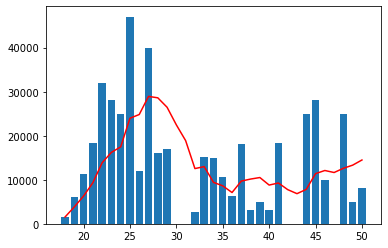

In [13]:
df_work_by_Week = df_cal.groupby(["mc_week"])["work_in_m"].sum()
df_work_sma = df_work_by_Week.rolling(window=7, min_periods=1).mean()
plt.bar(df_work_by_Week.index, df_work_by_Week)
plt.plot(df_work_sma.index, df_work_sma, color="r")
plt.show()


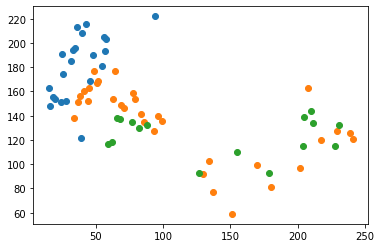

In [10]:
plt.scatter(
    df_cal.index[df_cal["session_type_group"] == "2km Row"],
    df_cal["power_in_avg_w"][df_cal["session_type_group"] == "2km Row"],
)
plt.scatter(
    df_cal.index[df_cal["session_type_group"] == "5km Row"],
    df_cal["power_in_avg_w"][df_cal["session_type_group"] == "5km Row"],
)
plt.scatter(
    df_cal.index[df_cal["session_type_group"] == "10km Row"],
    df_cal["power_in_avg_w"][df_cal["session_type_group"] == "10km Row"],
)
plt.show()


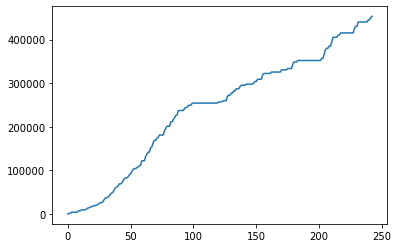

In [11]:
work_cum_in_m = df_cal["work_in_m"].cumsum()
plt.plot(work_cum_in_m.index, work_cum_in_m)
plt.show()
